In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import FlickrDataLoader
import torchvision.transforms as transforms
import PIL
from model import CaptionModel

with open('dict6k.pkl','r') as f:
    (w2id, id2w) = pickle.load(f)
id2w[5833] = '<end>'
    
img_dir = r'./data/img/Flicker8k_Dataset/'
cap_path = r'./data/label/Flickr8k.lemma.token.txt'
train_txt = r'./data/label/Flickr_8k.trainImages.txt'
val_txt = r'./data/label/Flickr_8k.devImages.txt'
test_txt = r'./data/label/Flickr_8k.testImages.txt'

mytransform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )
flicker8k_test = FlickrDataLoader.Flicker8k(img_dir, cap_path, test_txt, transform=mytransform, train=False)

with open('feat_test.npy','r') as f:
    feat_test = np.load(f)

In [12]:
def show_attention(image, alphas, preds):
    img_ = np.uint8(image.numpy().transpose(1,2,0)*255)
    img = PIL.Image.fromarray(img_).convert('L')

    plt.figure(figsize=(15,12))
    plt.subplot(np.ceil((len(preds)+1)*1.0/4),4,1)
    plt.imshow(img_)
    for iii in range(len(preds)):
        max_ = np.max(alphas[iii][0])
        att = alphas[iii][0]/max_ + 0.0/255
        att = PIL.Image.fromarray(np.uint8(att*255))

        att = att.resize((224,224), PIL.Image.ANTIALIAS)

        plt.subplot(np.ceil((len(preds)+1)*1.0/4),4,iii+2)
        plt.imshow(np.asarray(att).astype(float)*np.asarray(img).astype(float), cmap='gray')
        plt.title( preds[iii], fontsize=15)
    plt.show()

In [3]:
model = CaptionModel(bsz=1, feat_dim=(196, 512), n_voc=5834, n_embed=512, n_hidden=1024).cuda()

In [4]:
with open('model_epoch11.pth','r') as f:
    model.load_state_dict(torch.load(f))

In [5]:
def visual_attention(i):
    image,cpat = flicker8k_test[i]
    print('Handmade caption: '+cpat[0])
    model.eval()
    c = Variable(torch.FloatTensor(feat_test[i:i+1]), volatile=True).cuda()

    alphas,betas,preds = model.predict(c, 13, False)
    text_ = ''
    text2 = []
    for v in preds:
        if v==5832:
            text_ += '<start> '
            text2.append('<start>')
        elif v==5833:
            text_ += '<end> '
            text2.append('<end>')
            break
        else:
            text_ += id2w[v]+' '
            text2.append(id2w[v])
            if id2w[v]=='.':
                break
    print('generated caption: '+text_)
    show_attention(image, alphas, text2)

Handmade caption: a dog jump over a bar with a ball in its mouth .
generated caption: a collie jump over a hurdle and slide . 


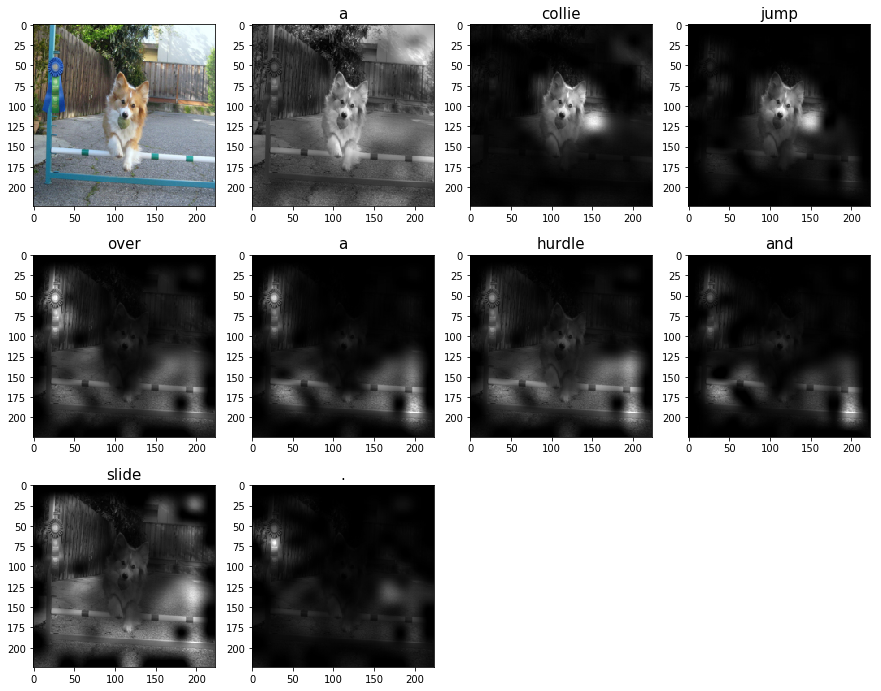

In [8]:
visual_attention(99)

Handmade caption: A dog chase a ball that have drop in the water .
generated caption: a dog jump over a stick . 


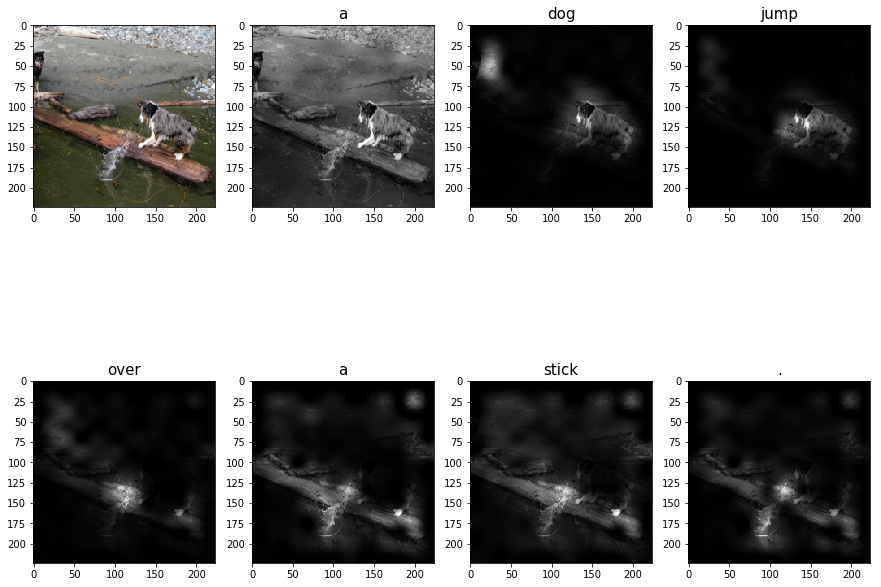

In [17]:
visual_attention(450)

Handmade caption: A cross-country skier have leave a trail behind him as he make his way through the snow .
generated caption: a person ski down a snowy hill . 


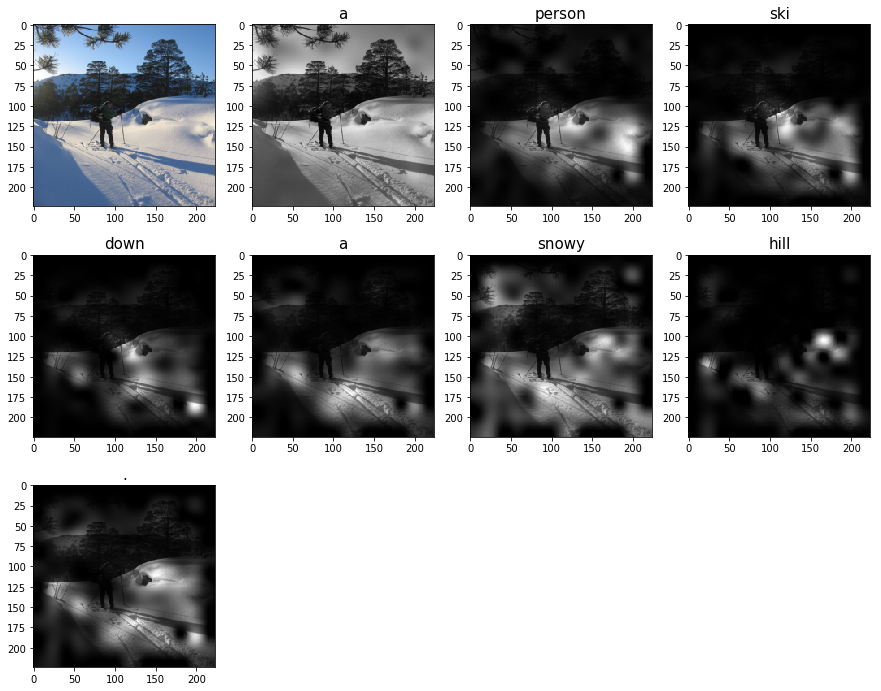

In [19]:
visual_attention(650)